# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '../../../../Downloads/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

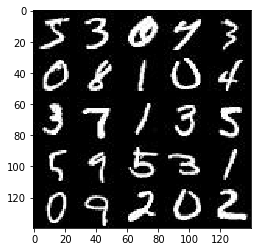

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

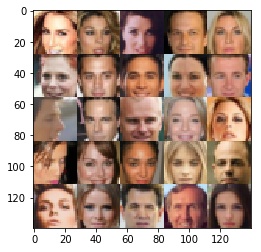

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_images')
    z_data = tf.placeholder(tf.float32, shape = [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [48]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha * x3, x3)
        # 3x3x256
        
        flat = tf.reshape(x3, (-1, 3*3*256) )
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [49]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')  # valid -> size: 2 * 3 + 1
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now
        
        
        # Output layer, 32x32xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [50]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [51]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [53]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # show stats every 10 batches
                if batch_i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show images every 100 batches
                if batch_i % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
            # end of Epoch images
            print('State of the art after epoch', epoch_i+1)
            show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.5853
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.6803


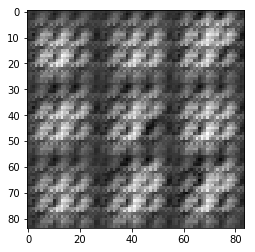

Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.7808


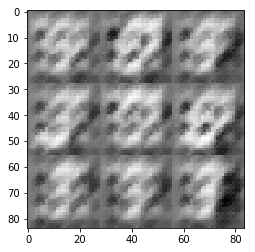

Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.7611
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.8152


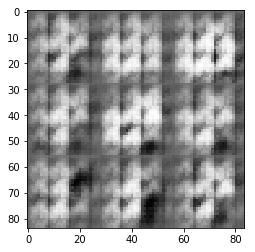

Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.7872
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 0.7286


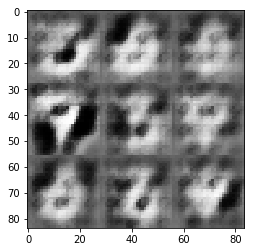

Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.7744


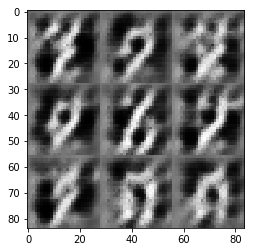

Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.7706
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.8264


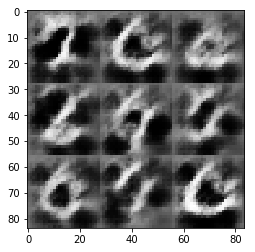

Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.7568


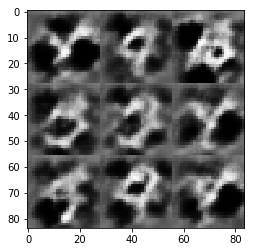

Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.7678
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.8097


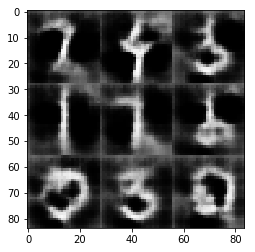

Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.7583


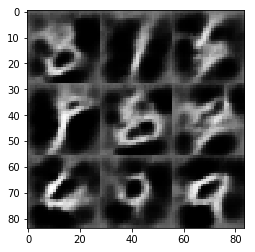

Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.7403
State of the art after epoch 1


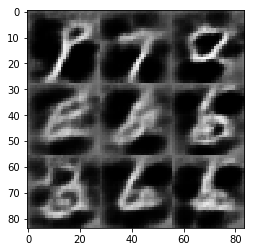

Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.7276


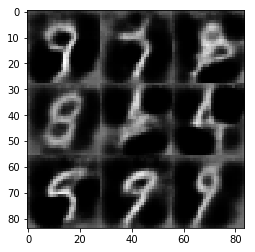

Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.3717... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.7821
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.7643


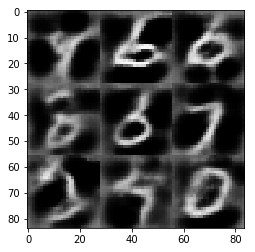

Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.7314
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.7406


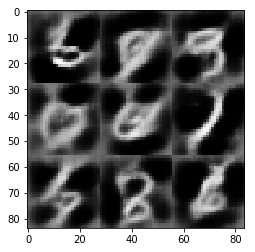

Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.8658


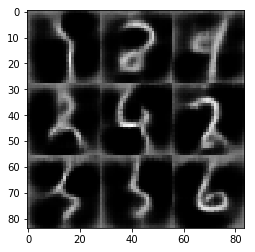

Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.3989... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.8079
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7077


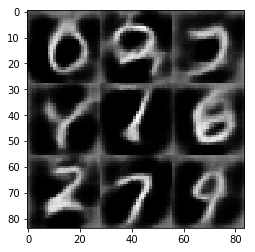

Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.8398
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.8107


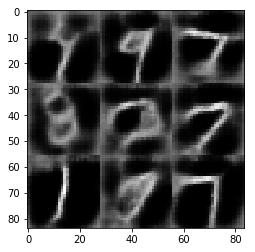

Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.7983


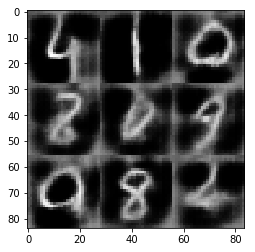

Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.9034
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.8812
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.7288


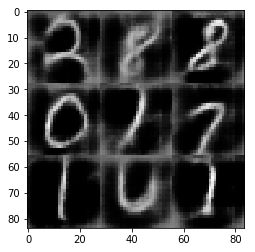

Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 0.6669
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.7160
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.7219


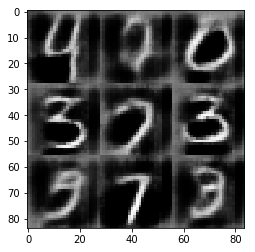

Epoch 2/2... Discriminator Loss: 1.3421... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.6352
State of the art after epoch 2


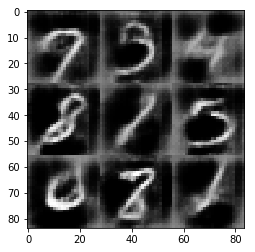

In [54]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7148


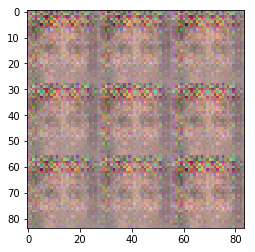

Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7586


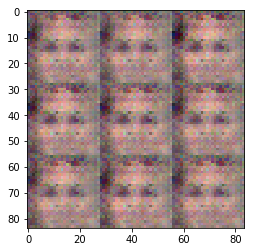

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8028


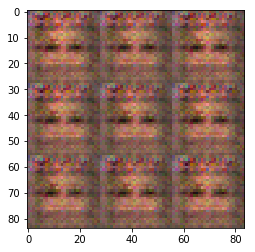

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7865


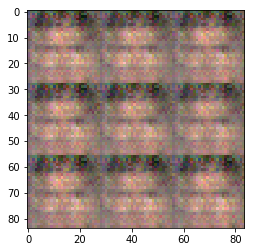

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6835


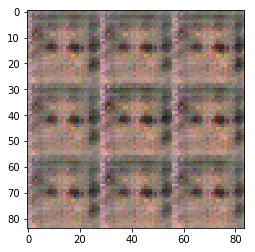

Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7508


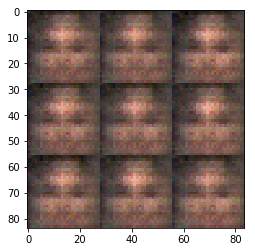

Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7686


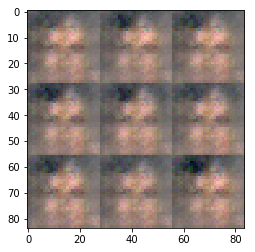

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7625


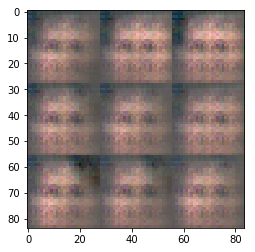

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8176


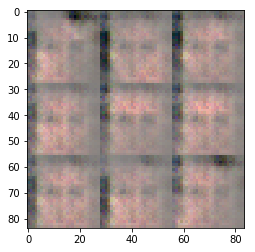

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7637


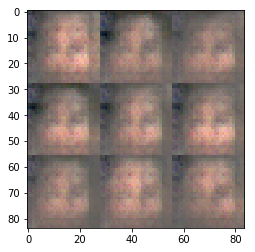

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7901


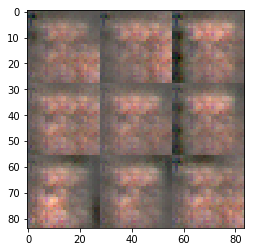

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7874


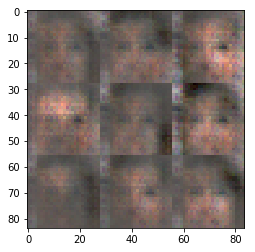

Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7911


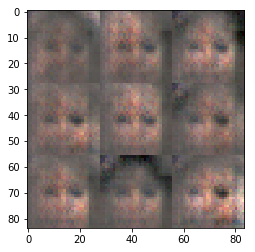

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8144


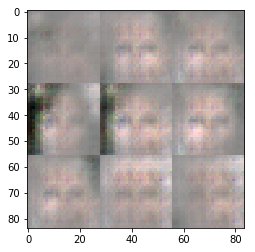

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7948


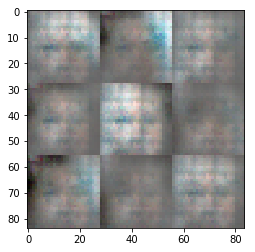

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7930


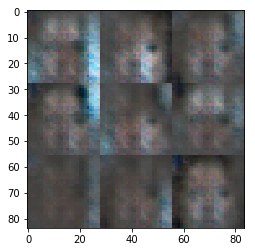

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7968


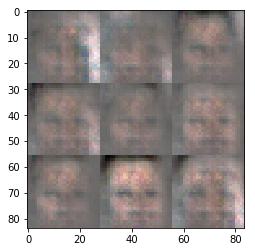

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7962


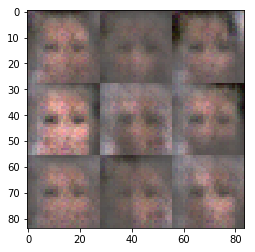

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7914


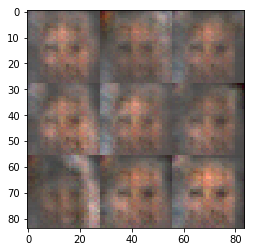

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7995


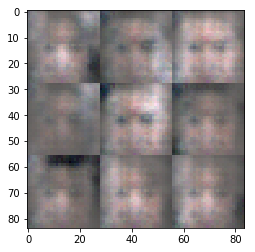

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7918


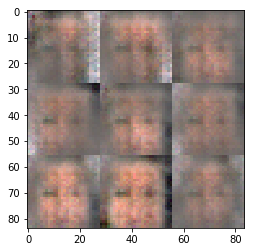

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7934


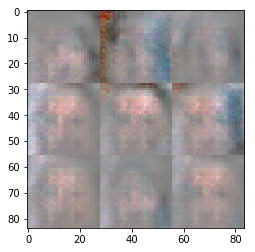

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7977


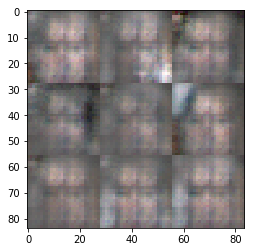

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8005


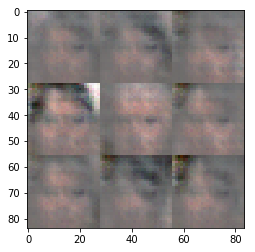

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7975


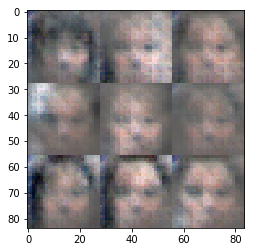

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8010


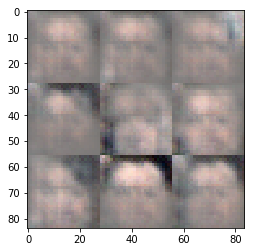

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7841


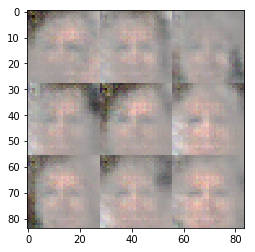

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7940


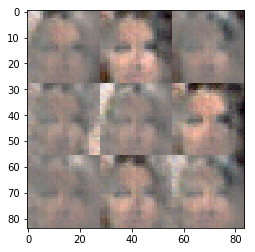

Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7955


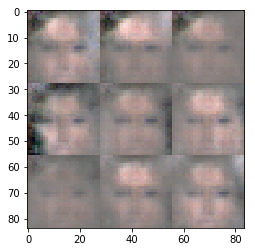

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7974


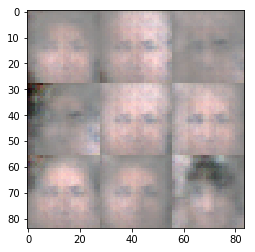

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7971


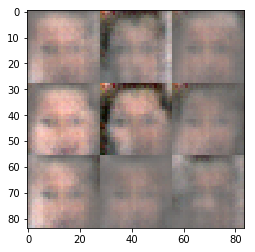

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7992
State of the art after epoch 1


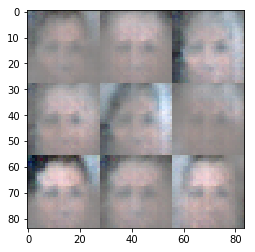

In [55]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.